In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=123):
    np.random.seed(seed)

set_seed(123)

In [2]:
DATA_DIR = os.path.abspath(os.path.join("..", "data"))
os.makedirs(DATA_DIR, exist_ok=True)
DATA_DIR

'C:\\Users\\prachinandi\\OneDrive - Microsoft\\Desktop\\Research Projects\\Academic-Projects-ml-lab\\ecal-transformer-reconstruction\\data'

In [3]:
CFG_DATA = {
    "grid_h": 48,
    "grid_w": 48,
    "topk": 128,
    "energy_min": 5.0,
    "energy_max": 200.0,

    # Shower width range (controls spread)
    "sigma_range": (1.2, 3.0),

    # Detector/electronics noise
    "noise_sigma": 0.02,

    # Multiplicative shower fluctuations (lognormal)
    "fluct_logn_sigma": 0.12,

    # Token selection threshold
    "threshold": 1e-4,

    "pileup": {
        "enabled": False,
        "mean_n_blobs": 12,
        "blob_sigma_range": (2.0, 6.0),
        "blob_amp_scale": 0.12,
    }
}

In [4]:
def simulate_one_shower_grid(rng: np.random.Generator, cfg: dict):
    H, W = cfg["grid_h"], cfg["grid_w"]
    Emin, Emax = cfg["energy_min"], cfg["energy_max"]
    smin, smax = cfg["sigma_range"]
    noise_sigma = cfg["noise_sigma"]
    fluct_sigma = cfg["fluct_logn_sigma"]

    # True photon energy
    E_true = rng.uniform(Emin, Emax)

    # Random shower center in continuous coordinates
    x0 = rng.uniform(0, W - 1)
    y0 = rng.uniform(0, H - 1)

    # Shower width
    sigma = rng.uniform(smin, smax)

    # Grid coordinates
    xs = np.arange(W)[None, :]
    ys = np.arange(H)[:, None]

    # Gaussian-ish shower profile
    r2 = (xs - x0) ** 2 + (ys - y0) ** 2
    prof = np.exp(-r2 / (2.0 * sigma * sigma)).astype(np.float32)

    # Normalize profile to sum to 1, then scale by E_true
    prof_sum = float(prof.sum() + 1e-12)
    grid = (E_true * prof / prof_sum).astype(np.float32)

    # Stochastic fluctuations
    fluct = rng.lognormal(mean=0.0, sigma=fluct_sigma, size=grid.shape).astype(np.float32)
    grid *= fluct

    # Adding electronics noise and clamp
    grid += rng.normal(0.0, noise_sigma, size=grid.shape).astype(np.float32)
    grid = np.clip(grid, 0.0, None)

    # adding multiple random low-amplitude blobs
    pileup = cfg.get("pileup", {"enabled": False})
    if pileup.get("enabled", False):
        mean_n = float(pileup.get("mean_n_blobs", 10))
        blob_smin, blob_smax = pileup.get("blob_sigma_range", (2.0, 6.0))
        amp_scale = float(pileup.get("blob_amp_scale", 0.1))

        n = rng.poisson(mean_n)
        for _ in range(n):
            cx = rng.uniform(0, W - 1)
            cy = rng.uniform(0, H - 1)
            bs = rng.uniform(blob_smin, blob_smax)

            # blob amplitude proportional to E_true but is much smaller
            amp = rng.uniform(0.0, amp_scale) * E_true

            r2b = (xs - cx) ** 2 + (ys - cy) ** 2
            blob = np.exp(-r2b / (2.0 * bs * bs)).astype(np.float32)
            blob /= float(blob.sum() + 1e-12)
            grid += (amp * blob).astype(np.float32)

    return grid, np.float32(E_true)

In [5]:
def grid_to_topk_tokens(grid: np.ndarray, cfg: dict):
    H, W = cfg["grid_h"], cfg["grid_w"]
    K = cfg["topk"]
    thr = cfg.get("threshold", 1e-6)

    flat = grid.reshape(-1)

    # get top-K indices efficiently
    if K < flat.size:
        idx = np.argpartition(flat, -K)[-K:]
        # sort those K indices by energy descending
        idx = idx[np.argsort(flat[idx])[::-1]]
    else:
        idx = np.argsort(flat)[::-1]

    energies = flat[idx]

    # threshold to remove near 0 tokens
    valid = energies > thr
    idx = idx[valid]
    energies = energies[valid]

    n_tok = min(len(idx), K)

    tokens = np.zeros((K, 4), dtype=np.float32)
    mask = np.zeros((K,), dtype=np.bool_)

    if n_tok > 0:
        idx = idx[:n_tok]
        energies = energies[:n_tok]

        ys = idx // W
        xs = idx % W

        x_norm = xs.astype(np.float32) / float(W - 1)
        y_norm = ys.astype(np.float32) / float(H - 1)

        e = energies.astype(np.float32)
        log_e = np.log(e + 1e-8).astype(np.float32)

        tokens[:n_tok, 0] = x_norm
        tokens[:n_tok, 1] = y_norm
        tokens[:n_tok, 2] = log_e
        tokens[:n_tok, 3] = e

        mask[:n_tok] = True

    return tokens, mask

Grid shape: (48, 48)
E_true: 155.9214324951172
Tokens shape: (128, 4) Valid tokens: 128


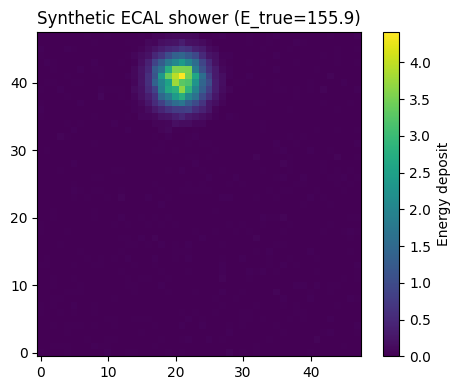

In [6]:
rng = np.random.default_rng(42)
grid, E_true = simulate_one_shower_grid(rng, CFG_DATA)
tokens, mask = grid_to_topk_tokens(grid, CFG_DATA)

print("Grid shape:", grid.shape)
print("E_true:", float(E_true))
print("Tokens shape:", tokens.shape, "Valid tokens:", int(mask.sum()))

plt.figure(figsize=(5,4))
plt.imshow(grid, origin="lower")
plt.title(f"Synthetic ECAL shower (E_true={E_true:.1f})")
plt.colorbar(label="Energy deposit")
plt.tight_layout()
plt.show()

In [7]:
def generate_split_npz(out_path: str, n_events: int, cfg: dict, seed: int):
    rng = np.random.default_rng(seed)

    K = cfg["topk"]
    tokens_arr = np.zeros((n_events, K, 4), dtype=np.float32)
    masks_arr  = np.zeros((n_events, K), dtype=np.bool_)
    truth_arr  = np.zeros((n_events,), dtype=np.float32)

    for i in range(n_events):
        grid, E_true = simulate_one_shower_grid(rng, cfg)
        tokens, mask = grid_to_topk_tokens(grid, cfg)

        tokens_arr[i] = tokens
        masks_arr[i] = mask
        truth_arr[i] = E_true

        if (i + 1) % max(1, (n_events // 10)) == 0:
            print(f"  progress: {i+1}/{n_events}")

    np.savez_compressed(out_path, tokens=tokens_arr, masks=masks_arr, truth=truth_arr)

In [8]:
N_TRAIN = 20000
N_VAL   = 5000
N_TEST  = 5000

train_path = os.path.join(DATA_DIR, "train.npz")
val_path   = os.path.join(DATA_DIR, "val.npz")
test_path  = os.path.join(DATA_DIR, "test.npz")

generate_split_npz(train_path, N_TRAIN, CFG_DATA, seed=123)
generate_split_npz(val_path,   N_VAL,   CFG_DATA, seed=456)
generate_split_npz(test_path,  N_TEST,  CFG_DATA, seed=789)

  progress: 2000/20000
  progress: 4000/20000
  progress: 6000/20000
  progress: 8000/20000
  progress: 10000/20000
  progress: 12000/20000
  progress: 14000/20000
  progress: 16000/20000
  progress: 18000/20000
  progress: 20000/20000
  progress: 500/5000
  progress: 1000/5000
  progress: 1500/5000
  progress: 2000/5000
  progress: 2500/5000
  progress: 3000/5000
  progress: 3500/5000
  progress: 4000/5000
  progress: 4500/5000
  progress: 5000/5000
  progress: 500/5000
  progress: 1000/5000
  progress: 1500/5000
  progress: 2000/5000
  progress: 2500/5000
  progress: 3000/5000
  progress: 3500/5000
  progress: 4000/5000
  progress: 4500/5000
  progress: 5000/5000


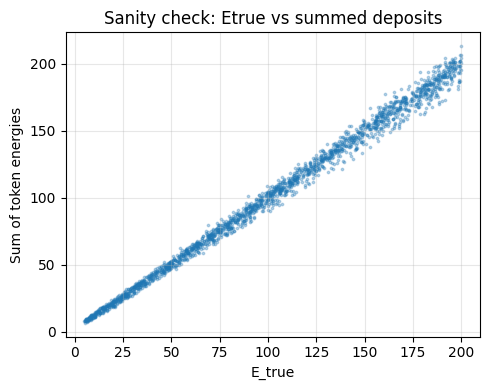

Correlation(Etrue, sumE) = 0.9970619219023967


In [14]:
d = np.load(train_path)
tokens = d["tokens"]
masks = d["masks"]
truth = d["truth"]

sumE = (tokens[..., 3] * masks).sum(axis=1)

plt.figure(figsize=(5,4))
plt.scatter(truth[:2000], sumE[:2000], s=3, alpha=0.3)
plt.xlabel("E_true")
plt.ylabel("Sum of token energies")
plt.title("Sanity check: Etrue vs summed deposits")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = np.corrcoef(truth, sumE)[0,1]
print("Correlation(Etrue, sumE) =", corr)